In [3]:
import sys
import tweepy
sys.path.insert(1, '../../')
import keys # tokens ficam acima da pasta do projeto
from datetime import datetime
import nltk
import string
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from unidecode import unidecode #
import os
import re
import gensim
import pickle #
import pyLDAvis.gensim #

%matplotlib inline

In [19]:
#api conf
auth = tweepy.OAuthHandler(keys.cos_pub, keys.cos_sec)
auth.set_access_token(keys.as_pub, keys.as_sec)

api = tweepy.API(auth) 
data_folder = '../data/'

In [20]:
#getting data
#TODO criar um gerador de termos de pesquisa
search_terms = [
    'lula',
    'presidente',
    'bosolnaro',
    'lulalivre',
    'stf',
    'vergonha nacional',
    'sergio moro',
    'pt',
    'brasil',
    'bolsominion',
    'segunda instância',
    'pec 410/18',
    'lava jato',
    'intercept',
    'vaza jato'
]
def twitter_search(terms):
    tmp_search_result = []
 
    for e in terms:
        partial_result = [];
        #API limita o acesso aos 100 ultimos tweets de uma pesquisa usando licensa não comercial
        api_result = api.search(q=e, tweet_mode='extended', count=100, lang='pt', retweeted=False, reply=False)

        for prop in api_result:
            partial_result.append(prop._json['full_text'])
        tmp_search_result.extend(partial_result)
        
    return tmp_search_result
search_result = set(twitter_search(search_terms)) # removendo tweets duplicados
search_result

{'"15 anos de PT no poder e eu continuo pobre, eles não acabaram com a pobreza?"\n\nAcabaram com a EXTREMA pobreza, gente que não tinha onde morar/comer/estudar/etc, mas você com IPHONE na mão vai reclamar que continua "pobre" 🤷🏻\u200d♂️',
 '"O STF TRAIU A NAÇÃO"\n"VAMOS A RUA CONTRA A IMPUNIDADE"\n"SERGIO MORO CHUPA MEU CU"\n\nnamoral? https://t.co/Hy1dJDWa96',
 '"Tenho parentes/amigos envolvidos no PT" é  o "tenho até amigos negros" da política. https://t.co/ZNwQaE3Vwp',
 '#QuemFoiMarighella claro e pujante qua a Globo quer "derrubar ou prejudicar o governo bosolnaro"',
 '#STF - \nSupremo desagradou aos cidadãos comuns de uma pátria, mas fez a festa dos #corruptos enjaulados. \nDe Petistas, passando por Tucanos e chegando a PSListas, haja devolução de favores... \nPior: há torcida fanatizada por alguns!\nReflexões em: https://t.co/lYDY9oSwRY\n.',
 '#STF VERGONHA NACIONAL...',
 '08/11/2019\nO DIA DA VERGONHA NACIONAL.\nO BRASIL \nESTÁ DE LUTO!',
 '20 ano de tesão \n\nLULA CORRE AQUI h

In [21]:
#saving data in a txt file

data_path = '{0}{1}/'.format(data_folder, datetime.now(tz=None))
graphics_path = data_path +'graphics/' 
separator = ' \n || \n '

os.makedirs(graphics_path)

#raw file
with open(data_path+'raw.txt', 'wb') as file:
    for e in search_result:
        entry = '{0}{1}'.format(e.splitlines(), separator) #tweet separator
        file.write(entry.encode())
    file.close()
    
#search terms
with open(data_path+'search_terms.txt', 'wb') as file:
    entry = ' '.join(search_terms)
    file.write(entry.encode())
    file.close()
    
with open(data_path+'raw_separator.txt', 'wb') as file:
    file.write(separator.encode())
    file.close()

In [33]:
#filtrando texto
def filter_text(txt):
    # juntando todas as sentenças e removendo \n
    text = ''.join(''.join(txt).splitlines())
    text = unidecode(text)
    #nltk.download('stopwords')
    stop_words = nltk.corpus.stopwords.words('portuguese')
    stop_words.extend(['', 'rt', 'nao', 'pra', 'q']) #tirando espaços vazios e marcas de retweet
    
    w_list = []
    w_list = text.split()
    w_list = [e.strip().strip(string.punctuation).lower() for e in w_list]
    w_list = filter(None, w_list)
    w_list = [e for e in w_list if "https" not in e and e[0] !=  '@'] #tirando  links e menções  
    
    w_filtered = ' '.join(w_list)
    
    #removendo caracteres não alfanuméricos de dentro da string e stop_words
    w_list = [e for e in re.sub('[^A-Za-z0-9]+', ' ', w_filtered).split(' ') if e not in stop_words ]
    w_filtered = ' '.join(w_list) #atualizando texto filtrado

    return {
        'text': w_filtered,
        'list': w_list
    }
text = filter_text(search_result)

words_list = text['list']
filtered_words = text['text']

print('List:\n{0}\n\nWords:'.format(words_list[:40]))
print(filtered_words[:200])

List:
['wienersoldier', 'gente', 'fala', 'mim', 'voces', 'idolatrando', 'lula', 'piada', 'so', 'meme', 'ver', 'bolsominion', 'puto', 'ne', 'passa', 'disso', 'ne', 'redetvt', 'lula', 'ja', 'chegou', 'sao', 'bernardo', 'campo', 'apoiadores', 'aguardam', 'pronunciamento', 'ex', 'presidente', 'frente', 'sindicato', 'met', 'claudioedantas', 'huck', 'pagando', 'favor', 'pt', 'financiamento', 'bndeseu', 'fico']

Words:
wienersoldier gente fala mim voces idolatrando lula piada so meme ver bolsominion puto ne passa disso ne redetvt lula ja chegou sao bernardo campo apoiadores aguardam pronunciamento ex presidente fren


In [34]:
filtered_sentenses = []
for e in search_result:
    filtered_sentenses.append(filter_text(e)['list'])

#filtered tweets
with open(data_path+'filtered_tweets.txt', 'wb') as file:
    tmpTxt = ''
    for e in filtered_sentenses:
        tmpTxt = tmpTxt + ' '.join(e) + '\n'
        
    file.write(tmpTxt.encode())
    file.close()    

print(filtered_sentenses)

[['wienersoldier', 'gente', 'fala', 'mim', 'voces', 'idolatrando', 'lula', 'piada', 'so', 'meme', 'ver', 'bolsominion', 'puto', 'ne', 'passa', 'disso', 'ne'], ['redetvt', 'lula', 'ja', 'chegou', 'sao', 'bernardo', 'campo', 'apoiadores', 'aguardam', 'pronunciamento', 'ex', 'presidente', 'frente', 'sindicato', 'met'], ['claudioedantas', 'huck', 'pagando', 'favor', 'pt', 'financiamento', 'bndes'], ['fico', 'mt', 'emocionada', 'nesse', 'predio', 'cheio', 'bolsominion', 'bloco', 'fica', 'antifa'], ['carmelonetobr', 'clara', 'armacao', 'denuncia', 'falsa', 'globo', 'sobre', 'marielle', 'lancar', 'huck', 'candidato', '3', 'anos', 'antes', 'eleicao', 'soltar', 'lula', 'al', 'convulsao', 'convocar', 'povo', 'ruas', 'falando', 'mal', 'presidente', 'so', 'idiota', 've', 'armacao'], ['thibortotti', 'felipezanon', 'quase', 'deu', 'pt'], ['pt', 'fez', '6', 'x', '5', 'pt', 'ganhou', 'saltar', 'lula', 'crise', 'brasil', 'culpado', 'bosolnaro'], ['eusoumbc', 'comunicado', 'oficial', 'questao', 'estrate

In [35]:
#termos mais frequentes
frequence_list= []
frequence_list = Counter(words_list)

frequence_list.most_common(20)

[('lula', 221),
 ('stf', 116),
 ('brasil', 103),
 ('presidente', 92),
 ('prisao', 71),
 ('jato', 69),
 ('moro', 64),
 ('vergonha', 63),
 ('nacional', 62),
 ('pt', 59),
 ('instancia', 59),
 ('ja', 58),
 ('bosolnaro', 55),
 ('ser', 55),
 ('vai', 53),
 ('bolsonaro', 52),
 ('so', 51),
 ('segunda', 49),
 ('intercept', 46),
 ('sao', 45)]

In [36]:
word_cloud = WordCloud(max_font_size=50).generate(filtered_words)

with open(data_path+'filtered_words_soup.txt', "wb") as file:
    file.write(filtered_words.encode())
    file.close()

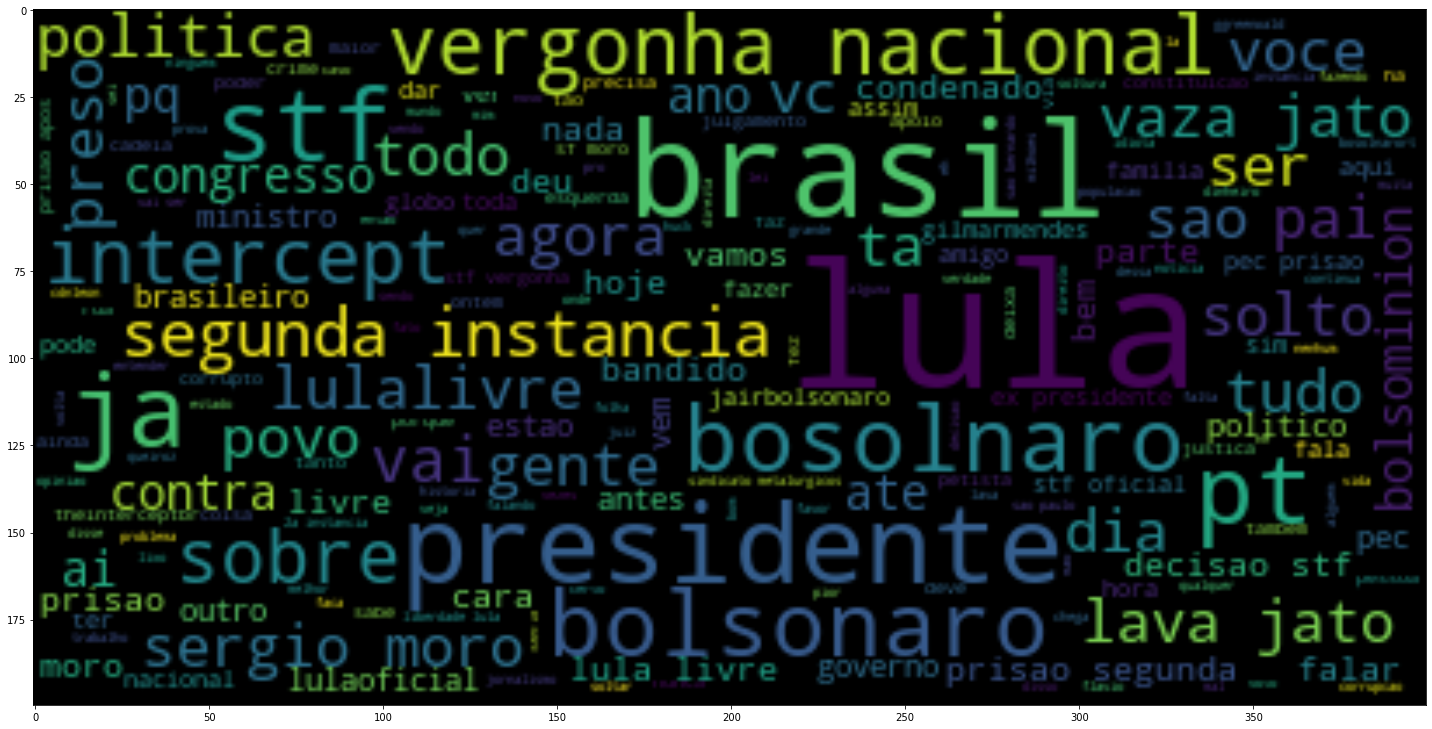

In [37]:
fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(word_cloud, interpolation='bilinear')
plt.axis(label= 'Nearest')
plt.tight_layout()
plt.savefig(graphics_path+'w_c_near.png', dpi=90)
plt.show()

In [39]:
#algoritmo que mostra vizinhos
expression = "politica"

positions = [] #localização onde a plavra se encontra
for i, e in enumerate(words_list):
    if expression == e:
        positions.append(i)

print(len(positions))
print(positions)

25
[351, 696, 1930, 2477, 2625, 2701, 2751, 2822, 3040, 3132, 4565, 5194, 5248, 5924, 6349, 6746, 6766, 6985, 7137, 7652, 8076, 8362, 8875, 9193, 9577]


In [40]:
neighbors = 2
for e in positions[0:30]:
    print(words_list[e-neighbors : e+neighbors+1])

['fiz', 's', 'politica', 'poucos', 'dias']
['prisao', 'lula', 'politica', 'cabralfmarcos', 'fizeram']
['maior', 'lideranca', 'politica', 'pais', 'ne']
['afetivas', 'luta', 'politica', 'celebracao', 'vitorias']
['politico', 'fazer', 'politica', 'alguem', 'eh']
['cambio', 'china', 'politica', 'social', 'desculpem']
['lpbragancabr', 'carreira', 'politica', 'lula', 'encerrou']
['exponho', 'opiniao', 'politica', 'situacao', 'brasil']
['amigos', 'negros', 'politica', 'ary', 'antipt']
['livre', 'briga', 'politica', 'nesse', 'site']
['pt', 'formacao', 'politica', 'internacional', 'entend']
['aguento', 'ouvir', 'politica', 'nessa', 'porcaria']
['ninguem', 'comentar', 'politica', '15', 'anos']
['nada', 'direito', 'politica', 'sabe', 'aconteceu']
['meio', 'tanta', 'politica', 'elitista', 'chegada']
['adquiriu', 'vida', 'politica', 'brasileira', 'suprema']
['pt', 'messianismo', 'politica', 'conciliacao', 'classe']
['injusticas', 'prisao', 'politica', 'presidente', 'lula']
['prisao', 'proposta', 'p

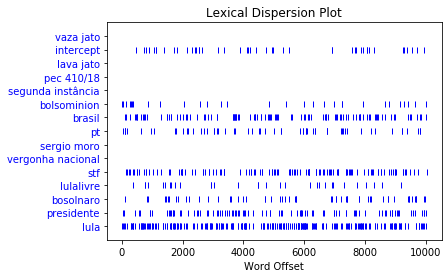

In [41]:
tknzr = nltk.tokenize.WordPunctTokenizer()
tokens = tknzr.tokenize(filtered_words)
nltk_text = nltk.Text(tokens)

nltk_text.dispersion_plot(search_terms)

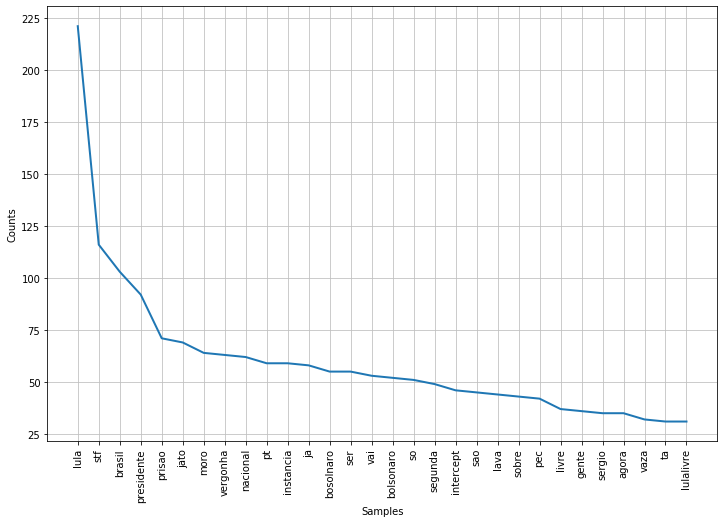

In [42]:
fd_words = nltk.FreqDist(tokens)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,8)) 
fd_words.plot(30)

In [43]:
#bag of words
corpus_path = data_path+'corpus.pkl'
dict_path = data_path+'dictionary.gensim'

dictionary = gensim.corpora.Dictionary(filtered_sentenses)
corpus = [dictionary.doc2bow(e) for e in filtered_sentenses]

#generating dict
pickle.dump(corpus, open( corpus_path, 'wb'))
dictionary.save(dict_path)

In [44]:
n_topics = 5 #número de tópicos
n_words = 5 #número de palavras relacionadas
lda_model_path = data_path+'my_cur_model_{0}t_{1}.gensim'.format(str(n_topics), str(n_words))

lda_model = gensim.models.ldamodel.LdaModel(corpus, num_topics = n_topics, id2word=dictionary, passes=15)
lda_model.save(lda_model_path)
topics = lda_model.print_topics(num_words= n_words) #palaras por array
for e in topics:
    print(str(e)+'\n')

(0, '0.013*"lula" + 0.009*"stf" + 0.008*"prisao" + 0.007*"moro" + 0.007*"bosolnaro"')

(1, '0.018*"brasil" + 0.012*"lula" + 0.008*"nacional" + 0.008*"stf" + 0.008*"vergonha"')

(2, '0.008*"stf" + 0.008*"nacional" + 0.007*"brasil" + 0.007*"presidente" + 0.007*"vergonha"')

(3, '0.029*"lula" + 0.011*"presidente" + 0.009*"prisao" + 0.008*"stf" + 0.007*"instancia"')

(4, '0.018*"lula" + 0.012*"jato" + 0.011*"stf" + 0.007*"vaza" + 0.006*"pt"')



In [45]:
#manter as duas tarefas de visualização das relações entre tópicos e palavras separadas, pois são tarefas demoradas
lda_display = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary, sort_topics=False)

/home/albrigs/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [46]:
pyLDAvis.display(lda_display)

In [47]:
print(search_terms)

['lula', 'presidente', 'bosolnaro', 'lulalivre', 'stf', 'vergonha nacional', 'sergio moro', 'pt', 'brasil', 'bolsominion', 'segunda instância', 'pec 410/18', 'lava jato', 'intercept', 'vaza jato']


In [48]:
print(data_path)

../data/2019-11-09 13:24:41.410511/
